# Digital Image Processing - HW5 - 98722278 - Mohammad Doosti Lakhani
In this notebook, I have solved the assignment's problems which are as follows:

1. Do the following tasks on `cameraman.jpg` image:
    1. Implement _**Canny Edge Detector**_ algorithm
    2. Extract Edges of the aforementioned image
    3. Use `cv2`'s Canny Edge Detector for task 2
    4. Compare results 
2. _**Hough**_ transform does not use gradient degree to obtain lines.
    1. Implement _**hough**_ transform which obtains lines in the image, but uses gradient degree in voting step. (Psuedocode is available in slide "shapeExtraction.pptx:p53"). Note that `theta` will be converted to `theta-delta_theta` and `theta+delta_theta`.
    2. Analyze the output of your implementation on `comb.jpg` image regarding multiple values of `delta_theta`
3. Do the following tasks on `page.png` image:
    1. Using `LineSegmentDetector` from `cv2`, extract the lines in the aforementioned image.
    2. By using **line intersection**, find the four corners of the page and draw it.
    3. Do the previous steps using `hough` transform from `cv2`
    4. Compare results
4. Align images using following steps:
    1. Find the relation between points on `page.png` image and a aligned paper using `findHomography`
    2. Cut the area using `warpPerspective`

## 1 Do the following tasks on cameraman.jpg image:
1. Implement Canny Edge Detector algorithm
2. Extract Edges of the aforementioned image
3. Use cv2's Canny Edge Detector for task 2
4. Compare results

![camera man image](images/cameraman.jpg)

### 1.A Implementation of Canny Edge Detector Algorithm
1. Gaussian Noise
2. Gradient Intensification
3. Non-Max Suppression
4. Thresholding

In [1]:
import cv2
import numpy as np
from scipy import ndimage
from PIL import Image

import matplotlib.pyplot as plt

import time
%matplotlib inline

In [87]:
def open_image(path):
    """
    Open an image using PIL library

    :param path: path to image file-like
    :return: PIL image object
    """
    image = Image.open(path)
    return image

In [88]:
def show_image(image, cmap='gray'):
    """
    Show PIL image or numpy image in default viewer of OS

    :param image: image data
    :param cmap: color map of input numpy array
    :return: None
    """
    if str(type(image)).__contains__('PIL'):
        image.show()
    elif str(type(image)).__contains__('numpy'):
        if cmap=='gray':
            Image.fromarray(np.uint8(image), mode='L').show()
        elif cmap == 'bw':
            size = image.shape[::-1]
            data_bytes = np.packbits(image, axis=1)
            Image.frombytes(mode='1', size=size, data=data_bytes).show()
        else:
            raise ValueError('color map is invalid.')
    else:
        raise ValueError('Input t is not valid.')

In [89]:
class ToGrayscale:
    """
    Get and PIL image or numpy n-dim array as image and convert it to grayscale image
    """

    def __init__(self):
        pass

    def __call__(self, image):
        """
        Get and PIL image or numpy n-dim array as image and convert it to grayscale image

        :param image: input image data
        :return: Grayscale image of input type
        """
        if str(type(image)).__contains__('PIL'):
            image = image.convert('L')
        elif str(type(image)).__contains__('numpy'):
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            raise ValueError('Input type is not valid.')
        return image

#### 1.A.a Gaussian Noise

In [90]:
class GaussianNoise:
    def __init__(self, size=5, std=1):
        self.size = size
        self.std = std

    def _gaussian(self, r2):
        """
        Sample one instance from gaussian distribution regarding
        given squared-distance:r2, standard-deviation:std and general-constant:k

        :param r: squared distance from center of gaussian distribution
        :param std: standard deviation

        :return: A sampled number obtained from gaussian
        """
        return np.exp(-r2/(2.*self.std**2)) / (2.*np.pi*self.std**2)
    
    def _gaussian_kernel(self):
        """
        Creates a gaussian kernel regarding given size and std.
        Note that to define interval with respect to the size, 
        I used linear space sampling which may has
        lower accuracy from renowned libraries.

        :param std: standard deviation value
        :param size: size of the output kernel
        :return: A gaussian kernel with size of (size*size)
        """
        self.size = int(self.size) // 2
        x, y = np.mgrid[-self.size:self.size+1, -self.size:self.size+1]
        distance = x**2+ y**2
        kernel = self._gaussian(r2=distance)
        return kernel
    
    def __call__(self, image):
        """
        Applies gaussian noise on the given image

        :param image: Input image in grayscale mode numpy ndarray or cv2 image
        :param size: Size of the gaussian kernel
        :param std: Standard deviation value for gaussian kernel
        """

        return ndimage.convolve(image, self._gaussian_kernel())

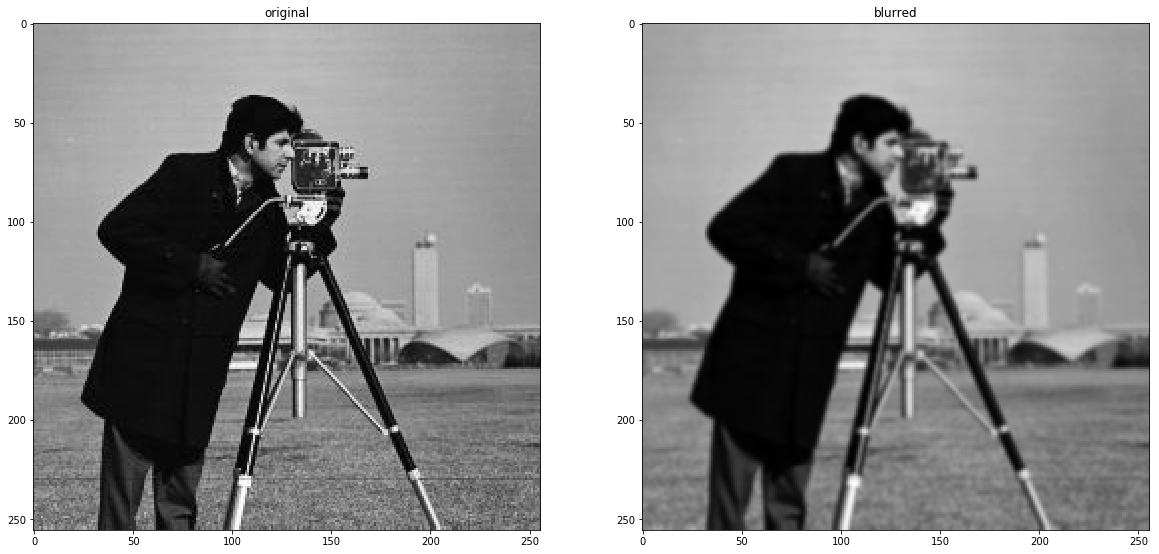

In [91]:
image = cv2.imread('images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)
gaussian_noise = GaussianNoise()
image_blurred = gaussian_noise(image)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].set_title('original')
ax[1].set_title('blurred')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_blurred, cmap='gray')

#### 1.A.b Gradient Intensity

In [92]:
class GradientIntensity:
    """
    We use Sobel filters to convolve over image (numpy ndarray) to calculate gradient intensity on both
    horizontal and vertical directions. Finally returns magnitude G and slope theta as follows:

    G = sqrt(Ix^2 + Iy^2)

    theta = arctan(Ix/Iy)

    We use these Sobel filters as default:

    Kx =
    [[-1 0 1],
    [-2 0 2],
    [-1 0 1]]

    Ky =
    [[1 2 1],
    [0 0 0],
    [-1 -2 -1]]

    """

    def __init__(self, hf=None, vf=None, init=True):
        """
        Initialize filters

        :param hf: Horizontal filter matrix -> numpy ndarray
        :param vf: Vertical filter matrix -> numpy ndarray
        :param init: whether initialize Sobel filters or initialize using user provided input -> default Sobel
        """

        if not init:
            self.hf = hf
            self.vf = vf
        else:
            self.hf = np.array(
                [[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])

            self.vf = np.array(
                [[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]])

    def __call__(self, x):
        if not str(type(x)).__contains__('numpy'):
            raise ValueError('Invalid input. Please provide numpy ndarray image.')
        Ix = ndimage.filters.convolve(x, self.hf)
        Iy = ndimage.filters.convolve(x, self.vf)

        G = np.sqrt(np.power(Ix, 2)  + np.power(Iy, 2))
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)

        return G, theta

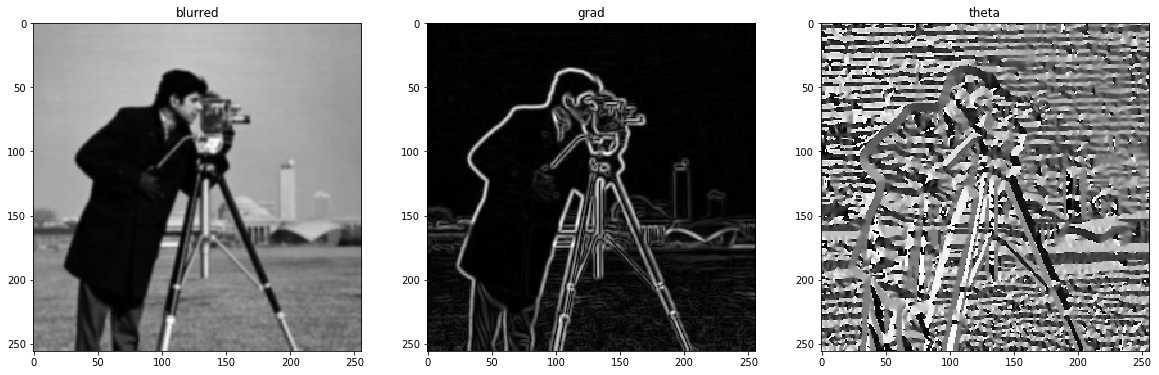

In [93]:
# image = cv2.imread('images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)
to_grayscale = ToGrayscale()
image = np.array(to_grayscale(open_image('images/cameraman.jpg')), dtype=float)  # this 'float' took me 7 hours!
gaussian_noise = GaussianNoise()
image_blurred = gaussian_noise(image)
gradient_intensity = GradientIntensity()
image_grad, image_theta = gradient_intensity(image_blurred)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
ax[0].set_title('blurred')
ax[1].set_title('grad')
ax[2].set_title('theta')
ax[0].imshow(image_blurred, cmap='gray')
ax[1].imshow(image_grad, cmap='gray')
ax[2].imshow(image_theta, cmap='gray')

#### 1.A.c Non-Max Suppression

In [94]:
class NonMaxSuppression:
    """
    Get gradient of image w.r.t the filters and degree of gradients (theta) and keep
    most intensified pixel in each direction.
    Note: d_prime = d-180
    """

    def __init__(self):
        pass

    def __call__(self, grad_img, grad_dir):
        """
        Get non-max suppressed image by preserving most intensified pixels

        :param grad_img: Gradient image gathered by convolving filters on original image -> numpy ndarray
        :param grad_dir: Gradient directions gathered by convolving filters on original image -> numpy ndarray
        :return: Soft-edge numpy ndarray image
        """

        z = np.zeros(shape=grad_img.shape, dtype=np.int32)

        for h in range(grad_img.shape[0]):
            for v in range(grad_img.shape[1]):
                degree = self.__angle__(grad_dir[h][v])

                try:
                    if degree == 0:
                        if grad_img[h][v] >= grad_img[h][v - 1] and grad_img[h][v] >= grad_img[h][v + 1]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 45:
                        if grad_img[h][v] >= grad_img[h - 1][v + 1] and grad_img[h][v] >= grad_img[h + 1][v - 1]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 90:
                        if grad_img[h][v] >= grad_img[h - 1][v] and grad_img[h][v] >= grad_img[h + 1][v]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 135:
                        if grad_img[h][v] >= grad_img[h - 1][v - 1] and grad_img[h][v] >= grad_img[h + 1][v + 1]:
                            z[h][v] = grad_img[h][v]
                except IndexError as exc:
                    # Handle boundary index errors
                    pass
        return z

    @staticmethod
    def __angle__(a):
        """
        Convert gradient directions in radian to 4 possible direction in degree system

        :param a: Radian value of gradient direction numpy ndarray matrix
        :return: A int within {0, 45, 90, 135}
        """
        angle = np.rad2deg(a) % 180
        if (0 <= angle < 22.5) or (157.5 <= angle < 180):
            angle = 0
        elif 22.5 <= angle < 67.5:
            angle = 45
        elif 67.5 <= angle < 112.5:
            angle = 90
        elif 112.5 <= angle < 157.5:
            angle = 135
        return angle

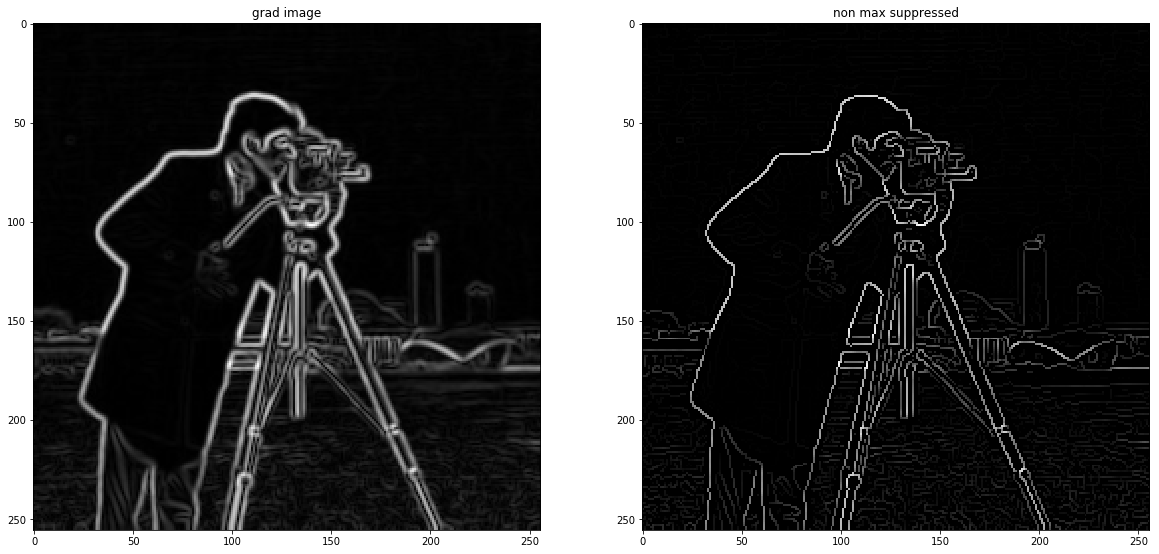

In [98]:
non_max_suppression = NonMaxSuppression()
image_non_max = non_max_suppression(image_grad, image_theta)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image_grad, cmap='gray')
ax[1].imshow(image_non_max, cmap='gray')
ax[0].set_title('grad image')
ax[1].set_title('non max suppressed')
plt.show()

#### 1.A.d Thresholding

In [106]:
class Thresholding:
    def __init__(self, high_threshold = 90, low_threshold = 30):
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.weak = 29
        self.strong = 255
        self.flag = self.weak*9
        
    def _threshold_image(self, image):
        thresholded = np.empty(image.shape)
        thresholded[np.where(image>self.high_threshold)] = self.strong
        thresholded[np.where(((image>self.low_threshold) & (image<=self.high_threshold)))] = self.weak
        return thresholded
    
    def __call__(self, image):
        thresholded = self._threshold_image(image)
        for i in range(thresholded.shape[0]):
            for j in range(thresholded.shape[1]):
                if thresholded[i, j] == self.weak:
                    if np.sum(thresholded[i-1:i+2, j-1:j+2]) > self.flag:
                        thresholded[i ,j] = self.strong
                    else:
                        thresholded[i ,j] = 0
        return thresholded

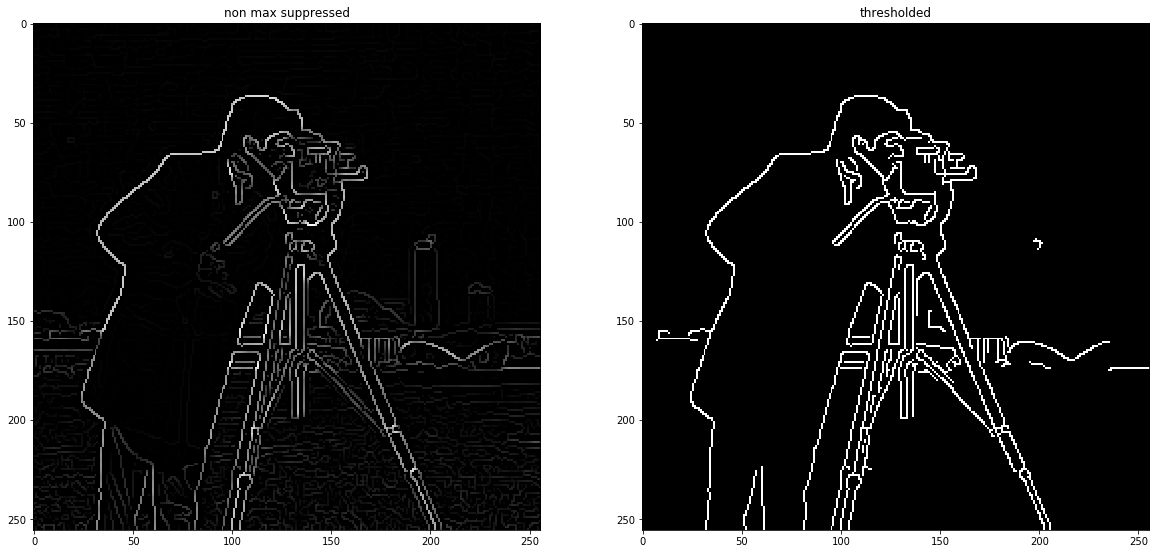

In [109]:
thresholding = Thresholding()
thresholded = thresholding(image_non_max)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image_non_max, cmap='gray')
ax[1].imshow(thresholded, cmap='gray')
ax[0].set_title('non max suppressed')
ax[1].set_title('thresholded')

plt.show()

### 1.B Extract Edges Using Your Approach

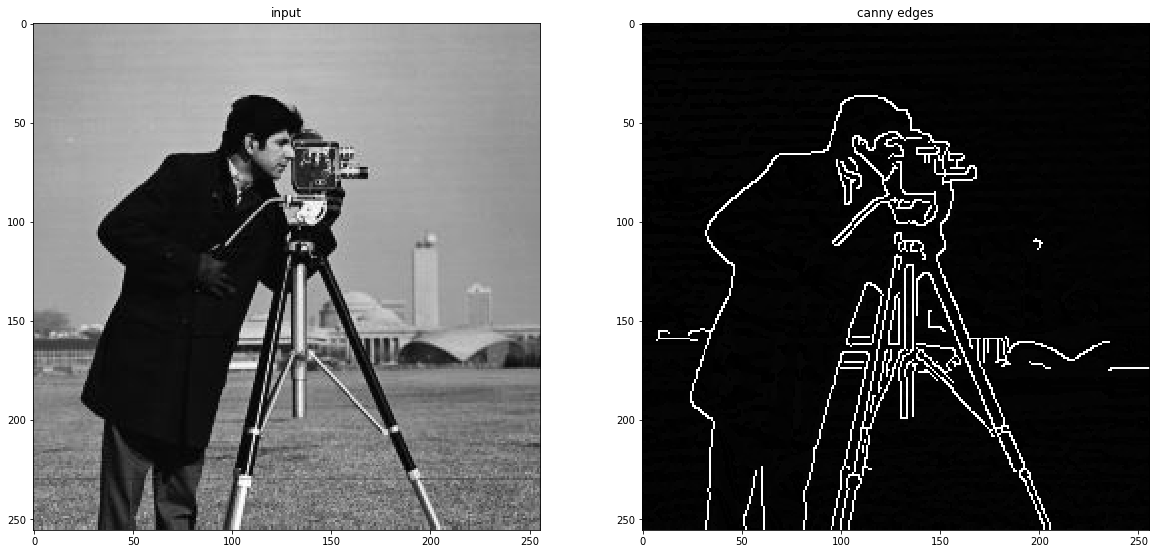

In [112]:
image = cv2.imread('images/cameraman.jpg', 0).astype(float)
t1 = time.time()
image_blurred = GaussianNoise()(image)
image_grad, image_theta = GradientIntensity()(image_blurred)
image_suppressed = NonMaxSuppression()(image_grad, image_theta)
image_final = Thresholding()(image_suppressed)
t1 = time.time()-t1

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_final, cmap='gray')
ax[0].set_title('input')
ax[1].set_title('canny edges')

plt.show()

### 1.C Use `cv2`'s Built-in Funtion to Extarct Edges

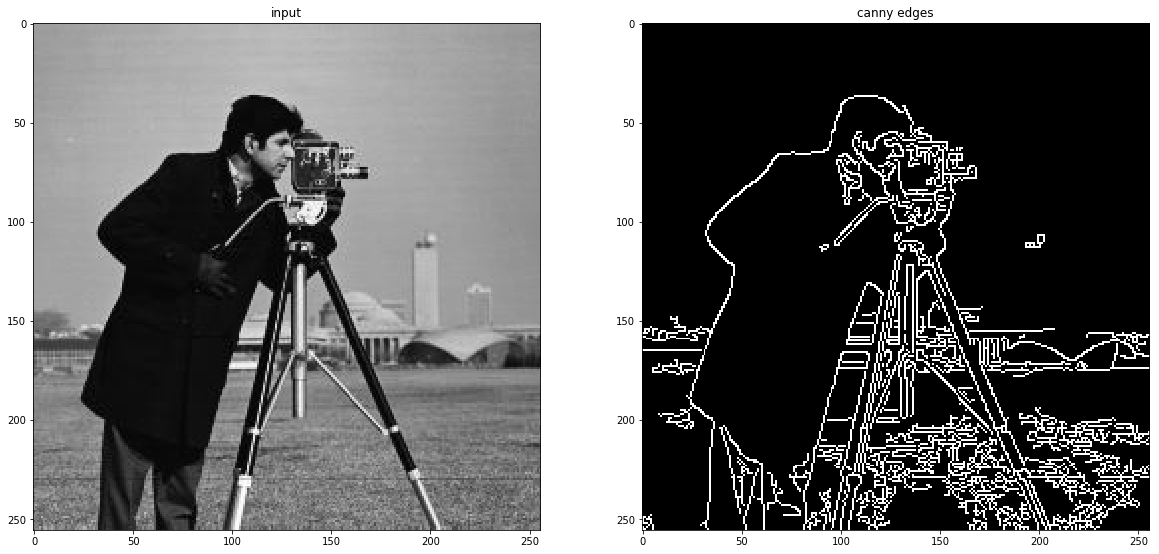

In [113]:
image = cv2.imread('images/cameraman.jpg', 0)
t2 = time.time()
image_cv_canny = cv2.Canny(image, 30, 255, L2gradient=True)
t2 = time.time() - t2

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_cv_canny, cmap='gray')
ax[0].set_title('input')
ax[1].set_title('canny edges')

plt.show()

### 1.D Compare Results

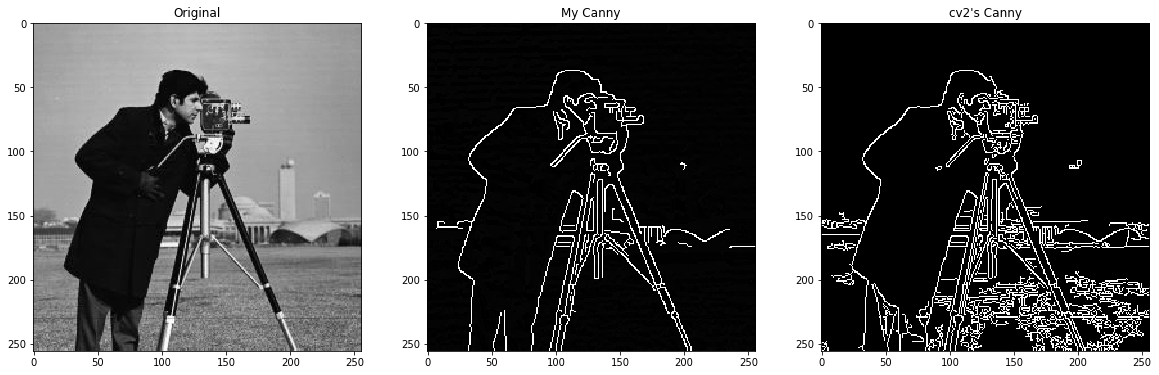

In [114]:
# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_final, cmap='gray')
ax[2].imshow(image_cv_canny, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('My Canny')
ax[2].set_title("cv2's Canny")

plt.show()

1. First of all, I used L2-Norm to reduce effect of noise edges like edges that can be extracted from field. Otherwise, these unnecessary details dominate other edges and I have used same threshold values for fair comparison.
2. Both algorithms failed to detect the edges of the tower which is because of light edges and consisting small number of pixel with light values.
3. OpenCV's algorithm finding more details which many of them are grass(field) and are unneccessary. Actually, if I am going to choose, I prefer my own even though it is much slower because of loops etc.
4. The time difference is profoundly huge (natural!!!) approximately my algorithm is **241** times slower than CV's.

In [114]:
print("Run time of my implementation: {} ~~~~~~~~ Run time of OpenCV's implementation: {}".format(t1, t2))

Run time of my implementation: 0.7049591541290283 ~~~~~~~~ Run time of OpenCV's implementation: 0.0029990673065185547


## 2. _**Hough**_ transform does not use gradient degree to obtain lines.
1. Implement _**hough**_ transform which obtains lines in the image, but uses gradient degree in voting step. (Psuedocode is available in slide "shapeExtraction.pptx:p53"). Note that `theta` will be converted to `theta-delta_theta` and `theta+delta_theta`.
2. Analyze the output of your implementation on `comb.jpg` image regarding multiple values of `delta_theta`

![comb.jpg](images/comb.jpg)

Psudocode of Hough:

![psudocode](wiki/psudo.jpg)

### 2.A Hough Transformation Implementation

In [254]:
def show_hough_line(img, accumulator, thetas, rhos):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(accumulator, cmap='gray')
    ax[1].set_ylim(-90, 90)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('rho')
    ax[1].set_ylabel('theta')
    ax[1].axis('image')

In [249]:
class Gradient_Oriented_Hough:
    """
    Calculates the Hough transform of the input (grayscale) image with consideration of gradient magnitude
    """
    def __init__(self):
        pass
    
    def __call__(self, image, delta_theta):
        """
        Gradient oriented Hough transform on grayscale image
        
        :param image: input image in form of ndarray or cv2 image
        :param delta_theta: Hypter-parameter to control theta resolution of accumulator quantization
        :return: A tuple of (Accumulator, rhos, linear_theta, gradient_magnitude)
        """
        # Getting edges and gradient magnitude using Canny
        image_grad, image_theta = GradientIntensity()(GaussianNoise()(image))
        edges = Thresholding()(NonMaxSuppression()(image_grad, image_theta))
        image_theta = np.array([a%180 for a in np.rad2deg(image_theta.flatten())]).reshape(image_grad.shape)

        # Gradient Oriented Hough
        diag_len = np.uint64(np.ceil(np.hypot(*edges.shape)))
        rhos = np.linspace(-diag_len/2, diag_len/2, diag_len)
        for_good_measure = 15  # just to have a better visualization
        accumulator = np.zeros((int(image_theta.max()+for_good_measure), int(diag_len)), dtype=np.int64)
        x_edges, y_edges = np.where(edges==255)
        for idx in range(len(x_edges)):
            x = x_edges[idx]
            y = y_edges[idx]
            if idx%delta_theta == 0:
                rho_ = int((x*np.cos(image_theta[x, y]) + y*np.sin(image_theta[x, y])) / 2) * 2
                accumulator[int(image_theta[x, y]), rho_] += 1
        return accumulator, rhos, np.deg2rad(np.arange(0, int(image_theta.max()))), image_theta

# usage
image = cv2.imread('images/comb.jpg', 0).astype(float)
accumulator, rhos, thetas, _ =  Gradient_Oriented_Hough()(image, 3)

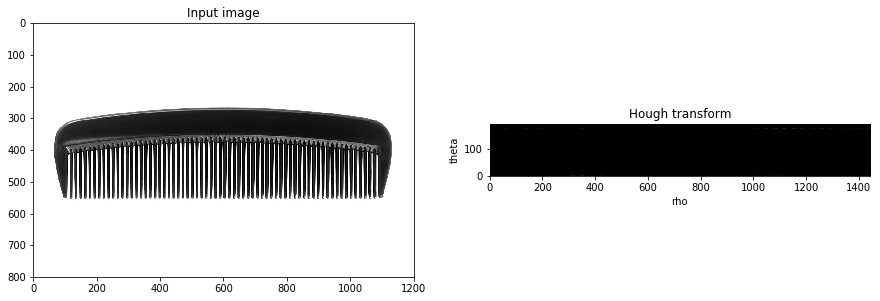

In [245]:
show_hough_line(image, accumulator, thetas, rhos)

In [246]:
class Hough:
    """
    Calculates Hough transform of a grayscale image
    """
    def __init__(self):
        pass
    
    def __call__(self, image, theta_res=90, delta_theta=1):
        """
        Calculates Hough transform of input image using base algorithm
        
        :param image: input ndarray numpy image or cv2 image
        :param theta_res: Theta resolution which will be distributed between (-theta_res, +theta_res) 
        :param delta_theta: Hypter-parameter to control theta resolution of accumulator quantization
        :return: A tuple of (Accumulator, rhos, thetas)
        """
        # Getting edges and gradient magnitude using Canny
        image_grad, image_theta = GradientIntensity()(GaussianNoise()(image))
        edges = Thresholding()(NonMaxSuppression()(image_grad, image_theta))

        # Basic Hough
        thetas = np.deg2rad(np.arange(-theta_res, theta_res, delta_theta))
        diag_len = np.uint64(np.ceil(np.hypot(*edges.shape)))
        rhos = np.linspace(-diag_len/2, diag_len/2, diag_len)
        accumulator = np.zeros((len(thetas), int(diag_len)), dtype=np.int64)
        x_edges, y_edges = np.where(edges==255)
        for idx in range(len(x_edges)):
            for j, t in enumerate(thetas):
                rho_ = int((x_edges[idx]*np.cos(t) + y_edges[idx]*np.sin(t)) / 2) * 2
                accumulator[j, rho_] += 1
        return (accumulator, rhos, thetas)

# usage
image = cv2.imread('images/comb.jpg', 0).astype(float)
accumulator, rhos, thetas =  Hough()(image, 45, 2)

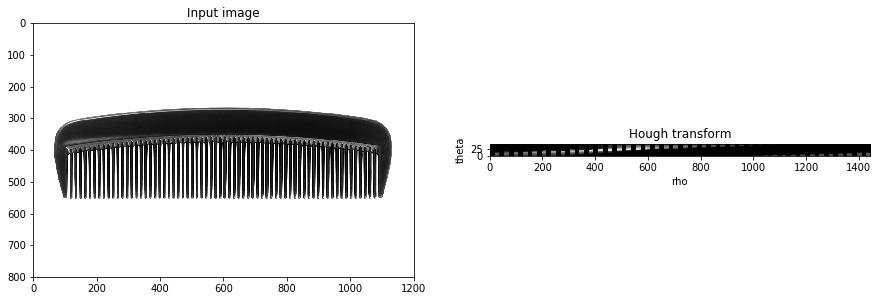

In [247]:
show_hough_line(image, accumulator, thetas, rhos)

### 2.B Analyze The Effect of `delta_theta` on Gradient Oriented Hough

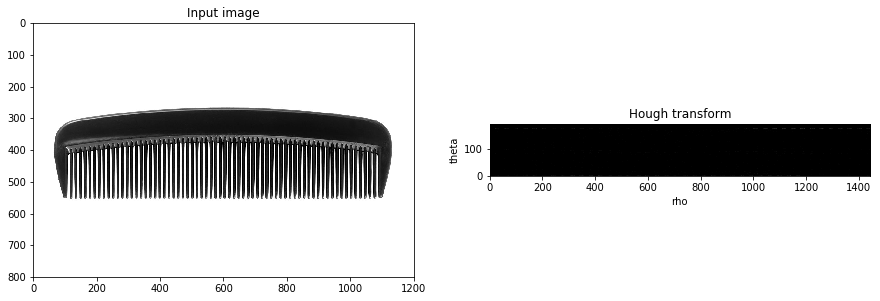

In [263]:
image = cv2.imread('images/comb.jpg', 0).astype(float)
accumulator, rhos, thetas, _ =  Gradient_Oriented_Hough()(image, 1)
show_hough_line(image, accumulator, thetas, rhos)

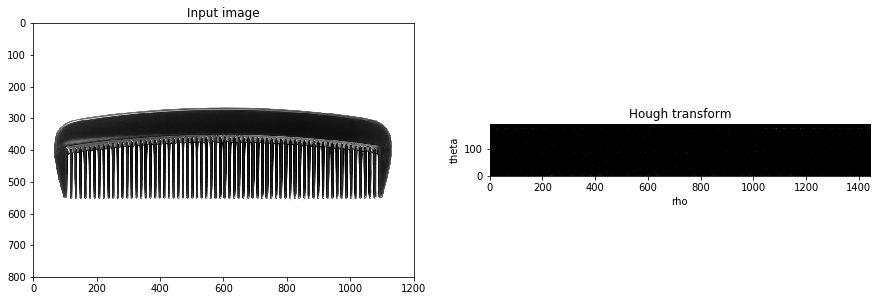

In [256]:
accumulator, rhos, thetas, _ =  Gradient_Oriented_Hough()(image, 5)
show_hough_line(image, accumulator, thetas, rhos)

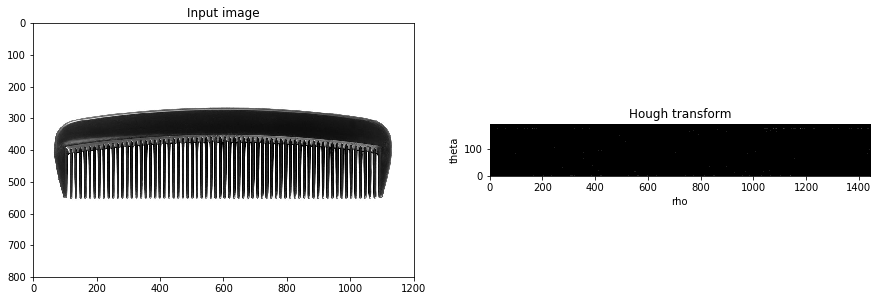

In [257]:
accumulator, rhos, thetas, _ =  Gradient_Oriented_Hough()(image, 15)
show_hough_line(image, accumulator, thetas, rhos)

To compare these images, I have used following values:
1. `delta_theta = 1` for first image
2. `delta_theta = 5` for second image
3. `delta_theta = 15` for third image

For the first one, it has same resolution as the base image gradient values so as we can see, there are lots of concentrated local maximas that are indicating our lines. But when we increase `delta_theta` values in the follow-up images, the intensity of concentrated areas decrease and in other areas of the transform, some new local maxiams can be found and when we increase `delta_theta` further, some of previously detected lines will be omitted and their votes will be shared by their neighbors or even distributed over the space.
The other point we can understand is that when we increase the `delta_theta` value, the accuracy decreases but generalizations increases in contrary and it is less reliable as we increase the value, because noises that previously has low votes and we did not consider them as line, are contributing to the desired lines which is not appropriate effect.

## 3 Do the following tasks on `page.png` image:
1. Using `LineSegmentDetector` from `cv2`, extract the lines in the aforementioned image.
2. By using **line intersection**, find the four corners of the page and draw it.
3. Do the previous steps using `hough` transform from `cv2`
4. Compare results

![page.png](images/page.png)

### 3.A Using `LineSegmentDetector` From `cv2, Extract The Lines of The image

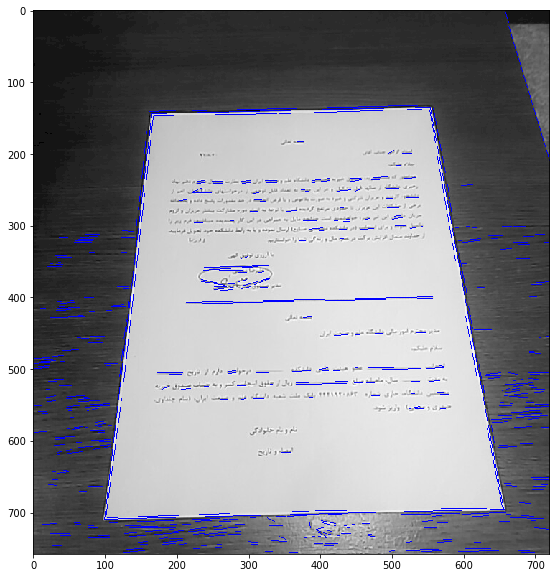

In [578]:
image = cv2.imread('images/page.png', 0)
lsd = cv2.createLineSegmentDetector(0)
lines = lsd.detect(image)[0]
drawn_image = lsd.drawSegments(image, lines)

# plotting
plt.figure(figsize=(20,10))
plt.imshow(drawn_image)
plt.show()

### 3.B Find The Corners Using `LineSegmentDetector`
The algorithm:
1. Extracting edges using available methods such as Canny
2. Segmenting image into background and target using flood fill algorithms
3. Extracting edges using available methods such as Canny, note that in this step, only the boundary of segmented areas exist
4. Finding intersections

#### 3.B.a Edge Extraction

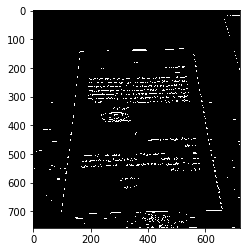

In [579]:
image = cv2.imread('images/page.png', 0)
edges = cv2.Canny(image, 150, 200)
plt.imshow(edges, cmap='gray')

#### 3.B.b Image Segmentation

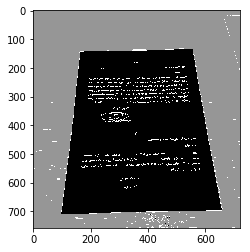

In [580]:
mask = np.zeros((image.shape[0]+2, image.shape[1]+2), np.uint8)
arbitrary = 150  # any value except 255 because edges are 255
flooded = cv2.floodFill(edges, mask, (0,0), arbitrary)[1]
plt.imshow(flooded, cmap='gray')

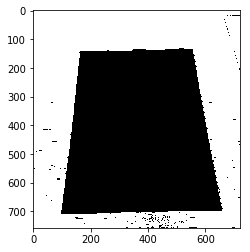

In [581]:
flooded_mask = np.zeros((flooded.shape))
flooded_mask[edges == arbitrary] = 255
plt.imshow(flooded_mask, cmap='gray')

#### 3.B.c Edge Extraction of Segmented Areas

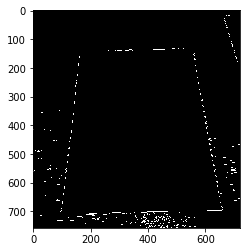

In [583]:
segmented_edges = cv2.Canny(np.uint8(flooded_mask), 100, 200, L2gradient=True)
plt.imshow(segmented_edges, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


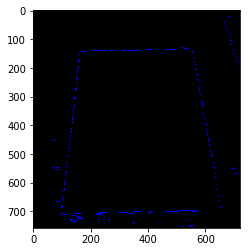

In [584]:
lsd = cv2.createLineSegmentDetector(0)
plane_ = np.zeros((segmented_edges.shape))
lines = lsd.detect(segmented_edges.astype('uint8'))[0]
drawn_image = lsd.drawSegments(plane_, lines)

# plotting
plt.imshow(drawn_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


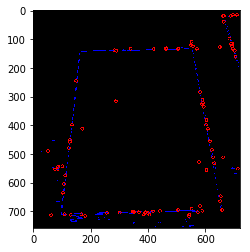

In [585]:
for l in range(len(lines)):
    xy = line_intersection(lines[l], lines[l-1], False)
    if xy[0]<0 or xy[1]<0 or xy[0]>plane.shape[0] or xy[1]>plane_.shape[1]:
        continue
#     print(xy)
    plane_ = cv2.circle(drawn_image, xy, 5, 255, 2)
plt.imshow(plane_)

In [586]:
def line_intersection(line1, line2, polar=False):
    if not polar:
        line1 = line1.reshape(2, 2)
        line2 = line2.reshape(2, 2)
        xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
        ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
           return -1, -1
        d = (det(*line1), det(*line2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return x, y
    else:
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        A = np.array([
            [np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]
        ])
        b = np.array([[rho1], [rho2]])
        try:
            x0, y0 = np.linalg.solve(A, b)
        except:
            return [-1, -1]
        x0, y0 = int(np.round(x0)), int(np.round(y0))
        return [x0, y0]
    

### 3.C Find The Corners Using `HoughLines`

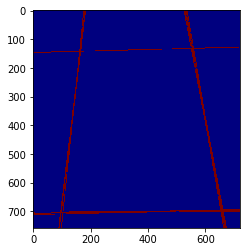

In [587]:
image = cv2.imread('images/page.png', 0)
plane = np.zeros(image.shape)
lines = cv2.HoughLines(segmented_edges, 0.77, np.pi / 183, 100, None, 0, 0)  # hyper-parameter tuned using grid search then manually!
# Draw the lines
if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(plane, pt1, pt2, (arbitrary, 234, arbitrary), 2, cv2.LINE_AA)
plt.imshow(plane, cmap='jet')

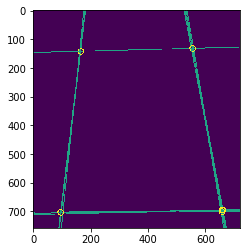

In [588]:
for l in range(len(lines)):
    xy = tuple(line_intersection(lines[l], lines[l-1], polar=True))
    if xy[0]<0 or xy[1]<0 or xy[0]>plane.shape[0] or xy[1]>plane.shape[1]:
        continue
    plane = cv2.circle(plane, xy, 10, 255, 2)
plt.imshow(plane)

### 3.D Compare Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Via "LSD"')

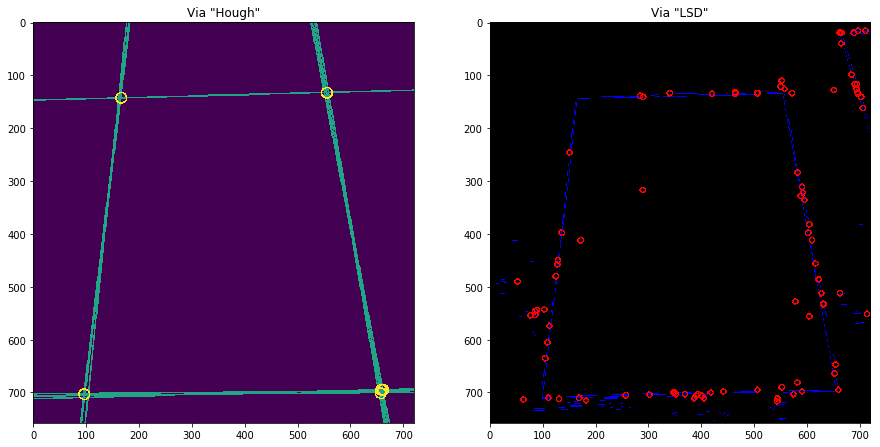

In [589]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(plane)
ax[1].imshow(drawn_image)
ax[0].set_title('Via "Hough"')
ax[1].set_title('Via "LSD"')

I would like to explain the procedure by mentioning that _**Hough**_ uses lines (not line segments) and because of that, there will not be multiple line segments in direction of a line as we can see in the images. In the image on the right, there are a lot of line segments on each line and because we have bunch of small line segments, the number of intersections is huge too. For instance, in the shown figures, **Hough** generated 5 intersection points which 2 of them overlap but **LSD** has created more than 150 intersection points which many of them are on same line.
On top of that, I have achieved almost very good answer by tuning the hyper-parameters of **Hough** because of simplicity.
One idea came to mind is that we need some kind of smoothing to consider all line segments in similar direction as a line but this process is exactly what **Hough** giving us without spliting line and rejoining them so this approach would be computationally expensive not rational at all. 

## 4 Align images using following steps:
1. Find the relation between points on `page.png` image and a aligned paper using `findHomography`
2. Cut the area using `warpPerspective`

### 4.A Find Relation Using `findHomography`

In [604]:
image = cv2.imread('images/page.png', 0)
points_ = [] 
for l in range(len(lines)):
    xy = tuple(line_intersection(lines[l], lines[l-1], polar=True))
    if xy[0]<0 or xy[1]<0 or xy[0]>plane.shape[0] or xy[1]>plane.shape[1]:
        continue
    points_.append(xy)

In [625]:
src_points = np.zeros((4, 2))
j = 0
for idx, p in enumerate(points_):
    if not (idx == 3 or idx == 4):
        src_points[j, 0] = p[0]
        src_points[j, 1] = p[1]
        j += 1
print(src_points)
dst_points = np.zeros((4, 2))
dst_points[0, 0] = image.shape[0]
dst_points[0, 1] = 0
dst_points[1, 0] = 0
dst_points[1, 1] = 0
dst_points[2, 0] = image.shape[0]
dst_points[2, 1] = image.shape[1]
dst_points[3, 0] = 0
dst_points[3, 1] = image.shape[1]
print(dst_points)

[[ 555.  133.]
 [ 166.  143.]
 [ 658.  695.]
 [  96.  703.]]
[[ 758.    0.]
 [   0.    0.]
 [ 758.  720.]
 [   0.  720.]]


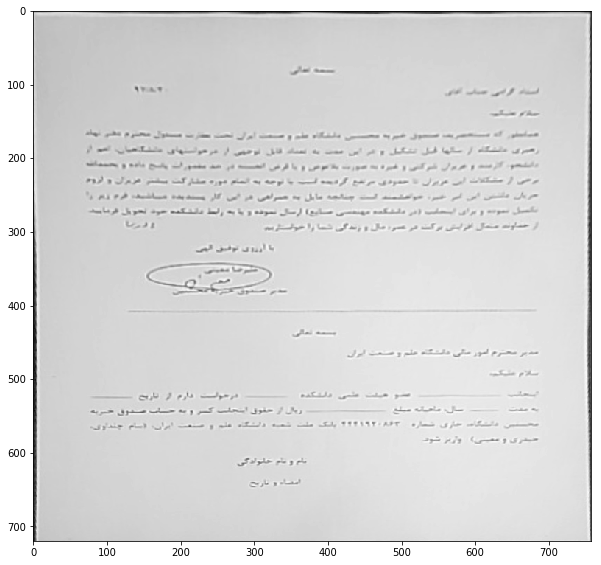

In [631]:
h, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC)
im1reg = cv2.warpPerspective(image, h, image.shape)

# plotting
plt.figure(figsize=(10,10))
plt.imshow(im1reg, cmap='gray')